As an alternative to the Correlation distance plots one can also compute the pure Kalman gain (with varying error/psm) and sum up the Kalman gains for each grid box to see how in total a location is influened by the proxy locations.

In [4]:
import sys
sys.path.append('/home/mchoblet/paleoda')
import xarray as xr
import numpy as np

from types import SimpleNamespace

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cartopy.crs as ccrs
from scipy.stats import linregress
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    

import warnings

import psm_pseudoproxy
import utils 
import evaluation

from scipy import stats
from matplotlib import ticker

In [6]:
#redux version of config dictionary

###CONFIG DICTIONARY

#lists are sometimes necessary, especially if we use multiple proxy-DBs (e.g. SISAL and iso2k)
#and multiple timescales

cfg={
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'avg':None,
'oro': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1600_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1600_1800.nc'],
'only_regional_proxies':False,
'regional_bounds':False,
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1,0.1], #irrelevant for PPE
'time_scales': ['median','median'],
'proxy_time':['0000','2015'],
'time': ['0000','2015'],
'resample': True,
'resample_mode': 'nearest',
'mask': 3, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'timescales':[1,3,6,12,24], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True,
'ppe': {'use':False},
'check_nan': False,
'reconstruct':['tsurf','d18O','prec']
}


cfg['psm']=['speleo','icecore']
cfg['interpol']=None
cfg['var_psm']=['d18O','d18O'] #only relevant if psm=None  
cfg['speleo']={
    'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': True, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'mean'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}
cfg['icecore']={
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': True, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
}

In [14]:
paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc',
       }
} 

#I checked once again that nothing with the longitudes is wrong (all go from 0 to 360)
oro_dic={
'iCESM':'/home/mchoblet/paleoda/data/orographies/icesm_oro.nc',
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/hadcm3_oro.nc',
}

In [25]:
def kalman_gain(cfg,time='YS',frac=1,R=0.5):
    """
    Compute kalman gain:
    
    time: resampling frequency (towards lower time resolutions)
    frac: Fraction of Proxy locations to use
    R: Error of proxies (maybe try values between 1 and 0.01, usually 0.1)
    
    1. load prior for all given variables
    2. load proxy locations
    3. Resample model data to higher resolutions
    4. Apply PSM
    5. Compute Correlation distance for each DB
    -> Return Data-Array
    
    """
    c=SimpleNamespace(**cfg)

    pp_y_all,pp_r_all=utils.proxy_load(c)
    prior, attributes, prior_raw=utils.prior_preparation(c)

    HXfull_all=utils.psm_apply(c,prior,prior_raw, pp_y_all)

    #resample after applying the psm, else things in fractionation can break
    prior=prior.resample(time=time,closed='left').mean()

    HXfull_all_new=[]
    for HX in HXfull_all:
        HX=HX.resample(time=time,closed='left').mean()
        HXfull_all_new.append(HX)

    HXf_=HXfull_all_new[0]
    if frac!=1:
        rng=np.random.default_rng()
        length=len(HXf_.site)
        HXf_=HXf_[:,rng.choice(length,size=int(length*frac), replace=False)]

    #HXf is only allowed to have time and site dimension
    HXf=xr.DataArray(HXf_.values,dims=('time','site'))
    HXf['time']=HXf_['time'].values
    HXf['site']=HXf_['site'].values

    kalman_ds=xr.Dataset()

    for v in c.reconstruct:
        print('compute kalman gain')
        Xf=prior[v].stack(z=('lat','lon'))
        #add a mini number first value to avoid nans (especially for precipitation)
        Xf[0,:]+=np.ones(Xf.shape[1])*1e-10

        #Compute Correlation Field:

        #cov Xf, HXf
        #cov HXf
        #R=0

        data=Xf.chunk({'z':250})
        cov=xr.cov(data,HXf,dim='time')

        covH=np.cov(HXf,rowvar=False)
        R_mat=np.diag(np.ones(len(HXf.site))*R)
        denom=covH+R_mat
        denom_inv=np.linalg.inv(denom)
        K=cov.values @ denom_inv

        data_array=xr.DataArray(K,coords=dict(z=cov.z,site=HXf.site))
        da_sum=data_array.sum(dim='site')
        da_sum=da_sum.unstack('z')
        
        kalman_ds[(str(v))]=(('lat','lon'),da_sum.values)
        try:
            kalman_ds=kalman_ds.drop('z')
        except:
            pass
        kalman_ds['lat']=prior.lat.values
        kalman_ds['lon']=prior.lon.values
    return kalman_ds

In [26]:
models=list(paths.keys())
times=[1]#,5,10,25]

dic_models={}
#loop over models
for m in models:
    model={}
    
    cfg['vp']=paths[m]
    
    if m=='iHadCM3':
        cfg['check_nan']=True
    else:
        cfg['check_nan']=False
        
    #dic_times={}
    #loop over timeranges
    #for t in times:
                
    time=str(t)+'YS'

    #just sisal, no psm
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1600_1800.nc']
    cfg['psm']=[None]
    c1=kalman_gain(cfg,time=time,frac=1)
    model['sisal_nopsm']=c1
    
    #add filter
    cfg['psm']=['speleo']
    cfg['speleo']={ 'weighting':None, 'height': False, 'fractionation':False, 'fractionation_temp': 'regular', 'filter': True, 't_time': 2.5, }
    c2=kalman_gain(cfg,time=time,frac=1)
    model['sisal_filter']=c2

    #add inf weighting
    cfg['psm']=['speleo']
    cfg['speleo']={ 'weighting':'inf', 'height': False, 'fractionation':False, 'fractionation_temp': 'regular', 'filter': False, 't_time': 2.5, }
    c2=kalman_gain(cfg,time=time,frac=1)
    model['sisal_inf']=c2
    
    #inf weighting + filter
    cfg['psm']=['speleo']
    cfg['speleo']={ 'weighting':'inf', 'height': False, 'fractionation':False, 'fractionation_temp': 'regular', 'filter': True, 't_time': 2.5, }
    c2=kalman_gain(cfg,time=time,frac=1)
    model['sisal_inf_filter']=c2
    
    # only fractionation
    cfg['psm']=['speleo']
    cfg['speleo']={ 'weighting': None, 'height': False, 'fractionation':True, 'fractionation_temp': 'regular', 'filter': False, 't_time': 2.5, }
    c2=kalman_gain(cfg,time=time,frac=1)
    model['sisal_frac']=c2
    
    # inf + fractionation
    cfg['psm']=['speleo']
    cfg['speleo']={ 'weighting': 'inf', 'height': False, 'fractionation':True, 'fractionation_temp': 'regular', 'filter': False, 't_time': 2.5, }
    c2=kalman_gain(cfg,time=time,frac=1)
    model['sisal_frac_inf']=c2
    
    #add full psm
    cfg['psm']=['speleo']
    cfg['speleo']={ 'weighting':'inf', 'height': False, 'fractionation':True, 'fractionation_temp': 'regular', 'filter': True, 't_time': 2.5, }
    c2=kalman_gain(cfg,time=time,frac=1)
    model['sisal_all']=c2
    
    #iso2k, no psm
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1600_1800.nc']
    cfg['psm']=[None]
    c3=kalman_gain(cfg,time=time,frac=1)
    model['iso_nopsm']=c3
    
    #iso2k prec
    cfg['psm']=['icecore']
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}
    c4=kalman_gain(cfg,time=time,frac=1)
    model['iso_prec']=c4
    
    #i2o2k filt
    cfg['psm']=['icecore']
    cfg['icecore']={'weighting': None, 'height': False, 'filter': True}
    c4=kalman_gain(cfg,time=time,frac=1)
    model['iso_filter']=c4
    
    #i2o2k all
    cfg['psm']=['icecore']
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': True}
    c4=kalman_gain(cfg,time=time,frac=1)
    model['iso_all']=c4
    
    """
    #both, no psm
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1600_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1600_1800.nc']
    cfg['psm']=[None,None]
    c5=kalman_gain(cfg,time=time,frac=1)

    #both, with psm
    cfg['psm']=['speleo','icecore']
    cfg['speleo']={ 'weighting':'inf', 'height': False, 'fractionation':True, 'fractionation_temp': 'regular', 'filter': False, 't_time': 2.5, }
    cfg['icecore']={'weighting': 'prec', 'height': False, 'filter': False}
    c6=kalman_gain(cfg,time=time,frac=1)

    #only karst-filter + inf
    #cfg['speleo']={ 'weighting':'inf', 'height': False, 'fractionation':False, 'fractionation_temp': 'regular', 'filter': True, 't_time': 2.5, }
    #c5=kalman_gain(cfg,time=time,frac=1)
    """
    
    #dic_times[str(t)]=[c1,c2,c3,c4,c5,c6] #[c1,c2,c3,c4,c5]

    dic_models[m]=model
    
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(dic_models, f)

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
compute 

100%|██████████| 103/103 [04:41<00:00,  2.74s/it]


compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 103/103 [04:44<00:00,  2.76s/it]


compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USIN

100%|██████████| 103/103 [04:46<00:00,  2.78s/it]


compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 103/103 [04:49<00:00,  2.81s/it]


compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yea

100%|██████████| 103/103 [05:36<00:00,  3.26s/it]


compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 103/103 [05:32<00:00,  3.22s/it]


compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsu

100%|██████████| 103/103 [04:55<00:00,  2.87s/it]


compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PRYSM ICECORE FILTER


100%|██████████| 103/103 [04:54<00:00,  2.86s/it]


compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
O

100%|██████████| 103/103 [05:23<00:00,  3.14s/it]


compute kalman gain
compute kalman gain
compute kalman gain
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
O

100%|██████████| 103/103 [05:20<00:00,  3.11s/it]


compute kalman gain
compute kalman gain
compute kalman gain


In [2]:
import pickle

In [29]:
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(dic_models, f)

In [3]:
with open('saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

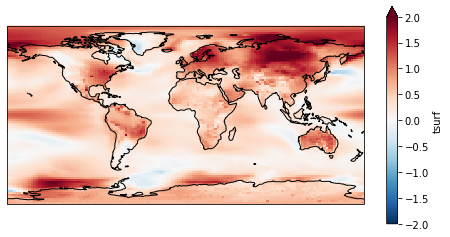

In [23]:
fig, ax = plt.subplots(figsize=(8,4),subplot_kw={'projection':ccrs.PlateCarree()})
loaded_dict['iCESM']['sisal_nopsm']['tsurf'].plot(vmax=2,vmin=-2,cmap='RdBu_r',ax=ax)
ax.add_feature(cfeature.COASTLINE)

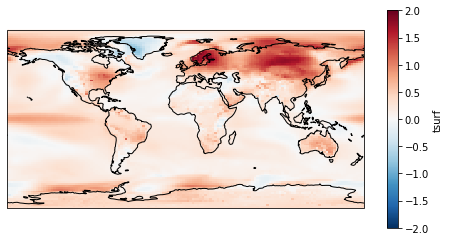

In [24]:
fig, ax = plt.subplots(figsize=(8,4),subplot_kw={'projection':ccrs.PlateCarree()})
loaded_dict['iCESM']['sisal_filter']['tsurf'].plot(vmax=2,vmin=-2,cmap='RdBu_r',ax=ax)
ax.add_feature(cfeature.COASTLINE)

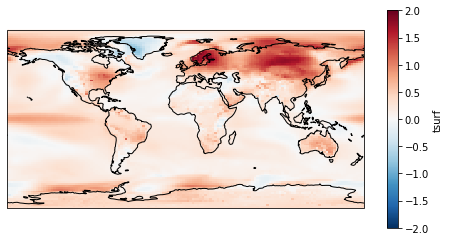

In [25]:
fig, ax = plt.subplots(figsize=(8,4),subplot_kw={'projection':ccrs.PlateCarree()})
loaded_dict['iCESM']['sisal_inf']['tsurf'].plot(vmax=2,vmin=-2,cmap='RdBu_r',ax=ax)
ax.add_feature(cfeature.COASTLINE)

In [37]:
gs = fig.add_gridspec(3, 2)

In [41]:
gs[0,1]

GridSpec(3, 2)[0:1, 1:2]

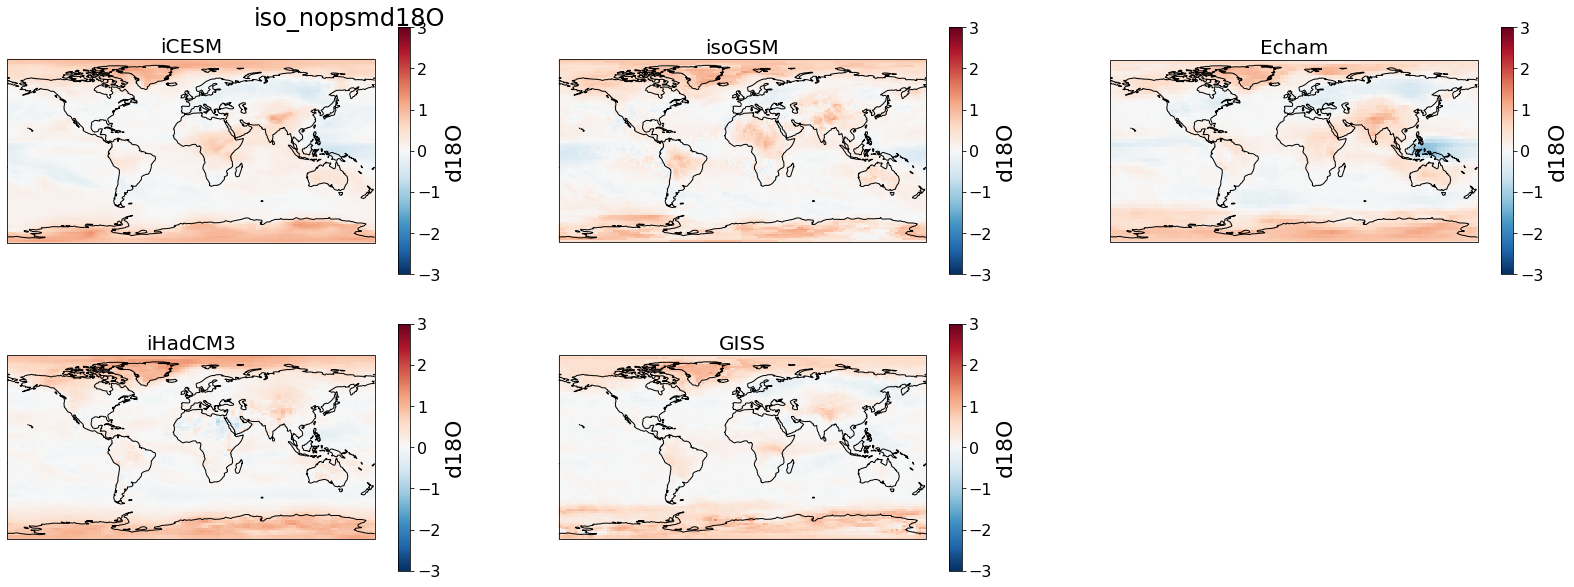

In [56]:
vmax=3
modus='iso_nopsm'
var='d18O'

fig = plt.figure(figsize=(28,10))
gs = fig.add_gridspec(2, 3)
#fig.suptitle(title,fontsize=40)

mpl.rcParams.update({'font.size': 22})

label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

for i,mod in enumerate(list(loaded_dict.keys())):
    #fig, ax = plt.subplots(figsize=(8,4),subplot_kw={'projection':ccrs.PlateCarree()})
    if i<3:
        i=i
        j=0
    else:
        i=5-i-1
        j=1
    
    ax = fig.add_subplot(gs[j,i], projection=ccrs.PlateCarree())
    if i==0 and j==0:
        ax.text(0.67, 1.18, (modus+' for '+var), transform=ax.transAxes, size=24)
    p=loaded_dict[mod][modus][var].plot(vmax=vmax,vmin=-vmax,cmap='RdBu_r',ax=ax)
    #loaded_dict[mod]['iso_nopsm']['d18O'].plot(vmax=vmax,vmin=-vmax,cmap='RdBu_r')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_title(mod,fontsize=20)

plt.show()

In [45]:
ax

<GeoAxesSubplot:title={'center':'iHadCM3'}, xlabel='lon', ylabel='lat'>

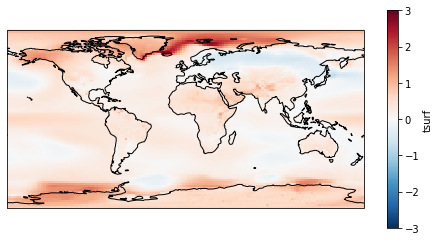

In [9]:
loaded_dict['iCESM'].keys()

dict_keys(['sisal_nopsm', 'sisal_filter', 'sisal_inf', 'sisal_inf_filter', 'sisal_frac', 'sisal_frac_inf', 'sisal_all', 'iso_nopsm', 'iso_prec', 'iso_all'])

In [35]:
loaded_dict['iCESM'].keys()

dict_keys(['sisal_nopsm', 'sisal_filter', 'sisal_inf', 'sisal_inf_filter', 'sisal_frac', 'sisal_frac_inf', 'sisal_all', 'iso_nopsm', 'iso_prec', 'iso_all'])

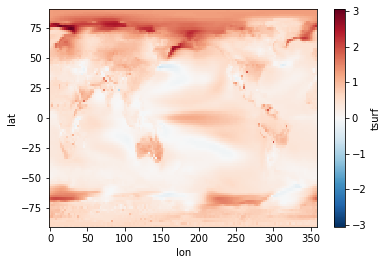

In [38]:
loaded_dict['iCESM']['sisal_inf_filter']['tsurf'].plot()

In [27]:
dic_models

{'iCESM': {'sisal_nopsm': <xarray.Dataset>
  Dimensions:  (lat: 96, lon: 144)
  Coordinates:
    * lat      (lat) float64 90.0 88.11 86.21 84.32 ... -84.32 -86.21 -88.11 -90.0
    * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  Data variables:
      tsurf    (lat, lon) float64 1.067 1.069 1.072 1.074 ... 0.695 0.669 0.6717
      d18O     (lat, lon) float64 -0.04948 -0.04968 -0.04914 ... 0.9497 0.9497
      prec     (lat, lon) float64 -0.0281 -0.0277 -0.02842 ... 0.4165 0.4165,
  'sisal_filter': <xarray.Dataset>
  Dimensions:  (lat: 96, lon: 144)
  Coordinates:
    * lat      (lat) float64 90.0 88.11 86.21 84.32 ... -84.32 -86.21 -88.11 -90.0
    * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  Data variables:
      tsurf    (lat, lon) float64 0.2757 0.2777 0.2798 ... 0.3687 0.3535 0.3521
      d18O     (lat, lon) float64 -0.276 -0.2763 -0.2758 ... 0.6127 0.6129 0.6129
      prec     (lat, lon) float64 -0.1085 -0.1081 -0.1087 ... 0.

# Plot 5 x 3 (for SISAL and Iso2k separately, because the combined effect can simply be got from adding both. Are there adverse effect?

- Temp, d18O, Prec.
- colorbar unten dran geklebt


* Sample: Map Plots


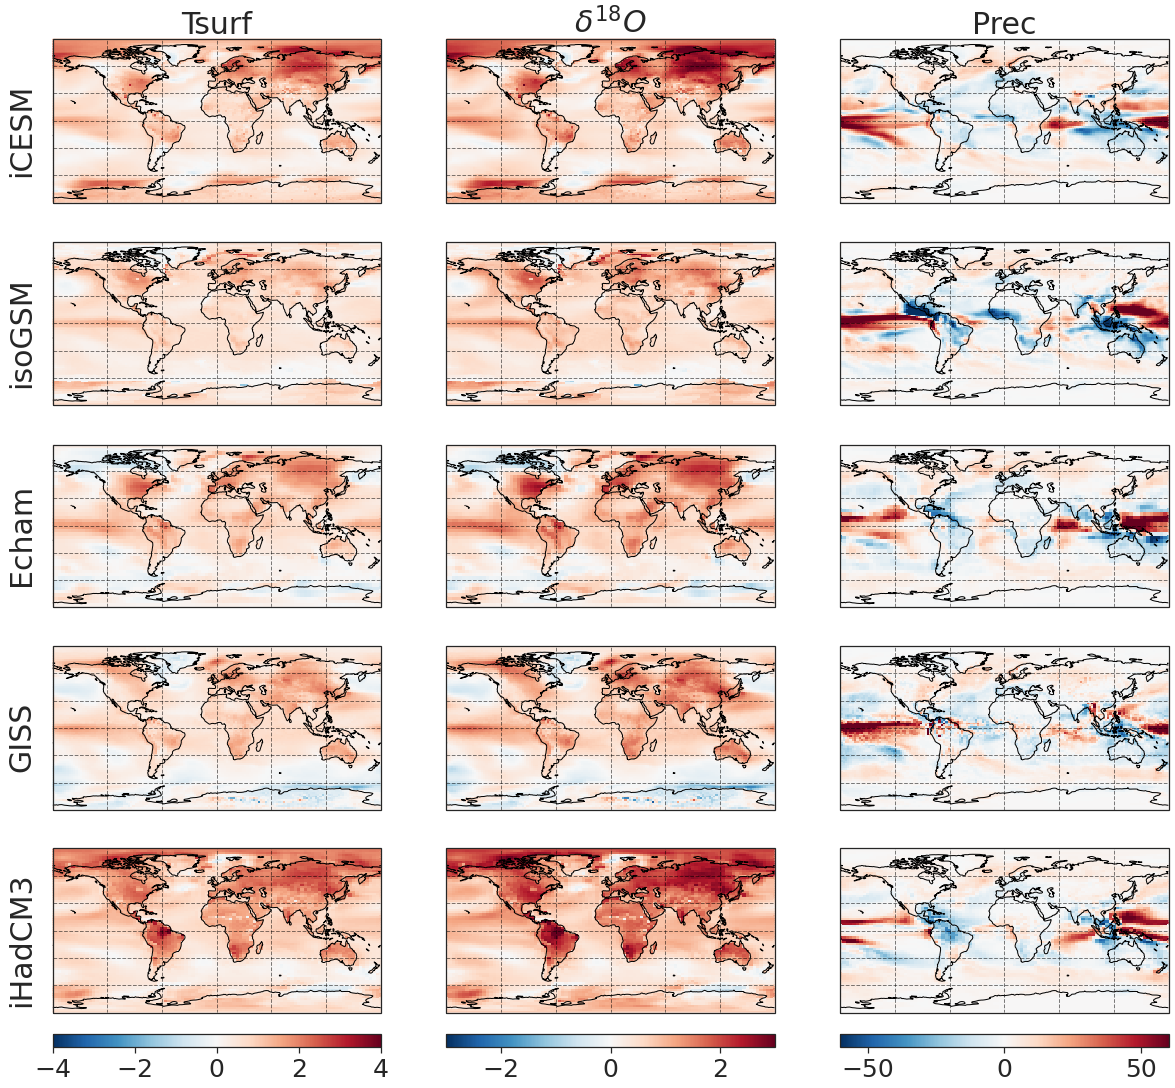

In [288]:
#### ONLY SISAL

sns.set_theme(style="white")

#get first list item
conf=0

figsize=(20,18)
fig, axes = plt.subplots(ncols=3,nrows=5,figsize=figsize,subplot_kw={'projection':ccrs.PlateCarree()})

for i,m in enumerate(models):
    
    data=dic_models[m]['1'][conf]
    
    #temperature
    vmin=-4; vmax=4
    p1=data['tsurf'].plot(ax=axes[i,0],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)
    
    ax=axes[i,0]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_ylabel(m,fontsize=30,rotation=90)
    ax.set_xlabel('',fontsize=30,rotation=0)
    ax.yaxis.set_label_coords(-0.05,0.45)

    
    #d18O
    vmin=-3; vmax=3
    p2=data['tsurf'].plot(ax=axes[i,1],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)

    ax=axes[i,1]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_ylabel('',fontsize=50,rotation=0)
    ax.set_xlabel('',fontsize=30,rotation=0)

    
    #precipitation
    vmin=-60; vmax=60
    p3=data['prec'].plot(ax=axes[i,2],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)
    
    ax=axes[i,2]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_xlabel('',fontsize=30,rotation=0)
    ax.set_ylabel('',fontsize=30,rotation=0)


    
p_0 = axes[-1,0].get_position().get_points().flatten()
p_1 = axes[-1,1].get_position().get_points().flatten()
p_2 = axes[-1,2].get_position().get_points().flatten()

ax_cbar = fig.add_axes([p_0[0], 0.1, p_0[2]-p_0[0], 0.01])
cbar=fig.colorbar(p1, cax=ax_cbar, orientation='horizontal')
#cbar=fig.colorbar(p1,ax=axes[-1,0],extend='max',aspect=12,pad=0.02,location='bottom')
cbar.ax.tick_params(labelsize=25)

ax_cbar = fig.add_axes([p_1[0], 0.1, p_1[2]-p_1[0], 0.01])
cbar=fig.colorbar(p2, cax=ax_cbar, orientation='horizontal')
cbar.ax.tick_params(labelsize=25)

ax_cbar = fig.add_axes([p_2[0], 0.1, p_2[2]-p_2[0], 0.01])
cbar=fig.colorbar(p3, cax=ax_cbar, orientation='horizontal')
cbar.ax.tick_params(labelsize=25)

"""
cm=plt.cm.RdBu_r    
ax_cbar1 = fig.add_axes([p1[0], 0.01, (p1[2]-p1[0]), 0.01])
cb=fig.colorbar(p1, cax=ax_cbar1, orientation='horizontal',cmap=cm)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
"""    

#cb.set_label('$\overline{{Proxy}}$ - $\overline{Simulation}$',fontsize=30)

axes[0,0].set_title('Tsurf',fontsize=30)
axes[0,1].set_title('$\delta^{18}O$',fontsize=30)
axes[0,2].set_title('Prec',fontsize=30)

plt.savefig('/home/mchoblet/paleoda/results/plots/thesis_draft/kalman_sisal.pdf', format='pdf',bbox_inches='tight')


#plt.tight_layout() 
    

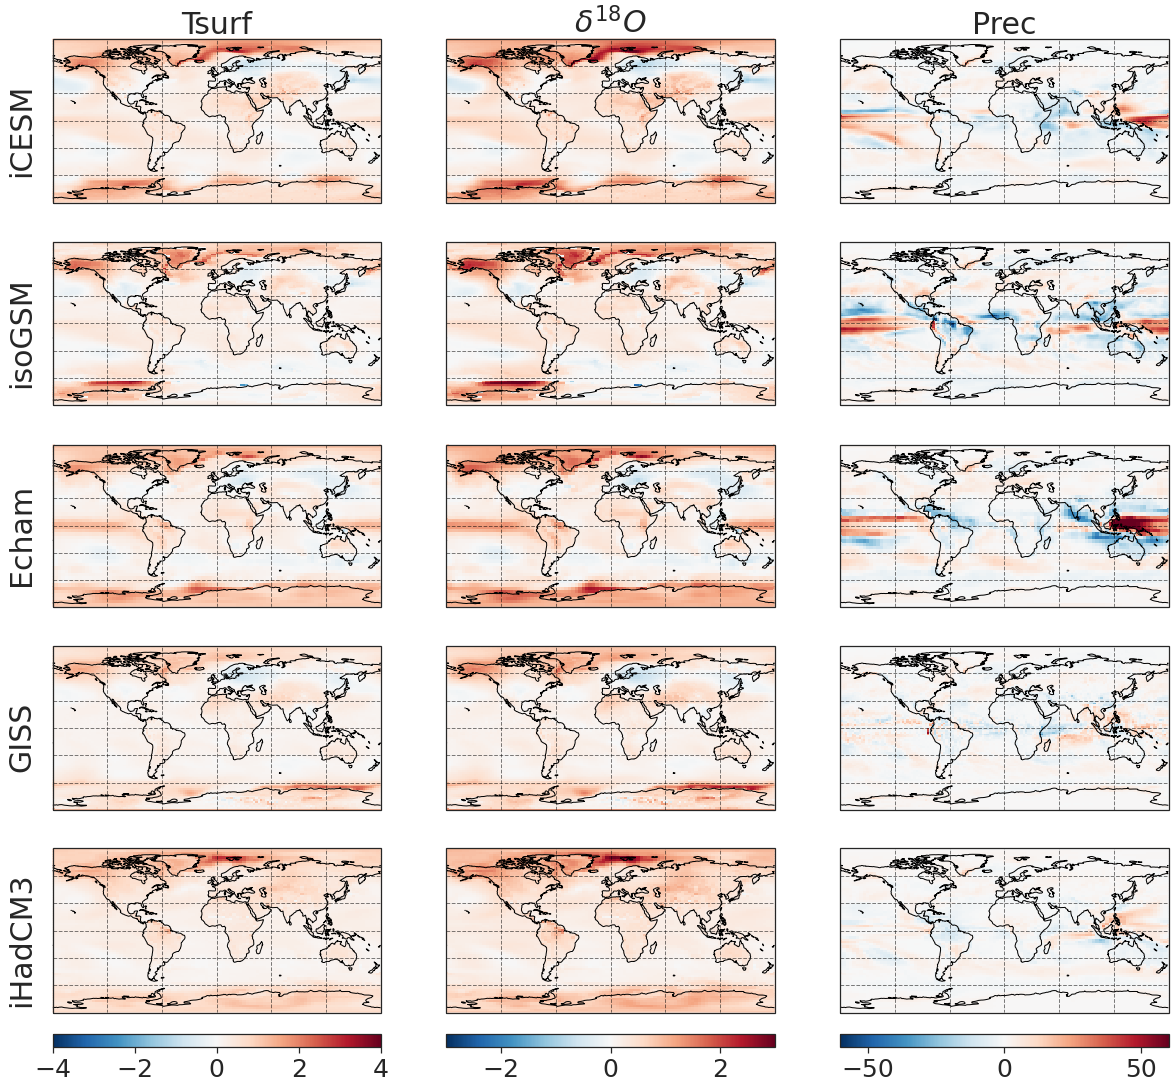

In [286]:
#ONLY ISO2K

sns.set_theme(style="white")

#get first list item
conf=2

figsize=(20,18)
fig, axes = plt.subplots(ncols=3,nrows=5,figsize=figsize,subplot_kw={'projection':ccrs.PlateCarree()})

for i,m in enumerate(models):
    
    data=dic_models[m]['1'][conf]
    
    #temperature
    vmin=-4; vmax=4
    p1=data['tsurf'].plot(ax=axes[i,0],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)
    
    ax=axes[i,0]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_ylabel(m,fontsize=30,rotation=90)
    ax.set_xlabel('',fontsize=30,rotation=0)
    ax.yaxis.set_label_coords(-0.05,0.45)

    
    #d18O
    vmin=-3; vmax=3
    p2=data['tsurf'].plot(ax=axes[i,1],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)

    ax=axes[i,1]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_ylabel('',fontsize=50,rotation=0)
    ax.set_xlabel('',fontsize=30,rotation=0)

    
    #precipitation
    vmin=-60; vmax=60
    p3=data['prec'].plot(ax=axes[i,2],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)
    
    ax=axes[i,2]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_xlabel('',fontsize=30,rotation=0)
    ax.set_ylabel('',fontsize=30,rotation=0)


    
p_0 = axes[-1,0].get_position().get_points().flatten()
p_1 = axes[-1,1].get_position().get_points().flatten()
p_2 = axes[-1,2].get_position().get_points().flatten()

ax_cbar = fig.add_axes([p_0[0], 0.1, p_0[2]-p_0[0], 0.01])
cbar=fig.colorbar(p1, cax=ax_cbar, orientation='horizontal')
#cbar=fig.colorbar(p1,ax=axes[-1,0],extend='max',aspect=12,pad=0.02,location='bottom')
cbar.ax.tick_params(labelsize=25)

ax_cbar = fig.add_axes([p_1[0], 0.1, p_1[2]-p_1[0], 0.01])
cbar=fig.colorbar(p2, cax=ax_cbar, orientation='horizontal')
cbar.ax.tick_params(labelsize=25)

ax_cbar = fig.add_axes([p_2[0], 0.1, p_2[2]-p_2[0], 0.01])
cbar=fig.colorbar(p3, cax=ax_cbar, orientation='horizontal')
cbar.ax.tick_params(labelsize=25)

"""
cm=plt.cm.RdBu_r    
ax_cbar1 = fig.add_axes([p1[0], 0.01, (p1[2]-p1[0]), 0.01])
cb=fig.colorbar(p1, cax=ax_cbar1, orientation='horizontal',cmap=cm)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
"""    

#cb.set_label('$\overline{{Proxy}}$ - $\overline{Simulation}$',fontsize=30)

axes[0,0].set_title('Tsurf',fontsize=30)
axes[0,1].set_title('$\delta^{18}O$',fontsize=30)
axes[0,2].set_title('Prec',fontsize=30)


plt.savefig('/home/mchoblet/paleoda/results/plots/thesis_draft/kalman_iso2k.pdf', format='pdf',bbox_inches='tight')


#plt.tight_layout() 
    

Text(0.5, 1.0, 'Prec')

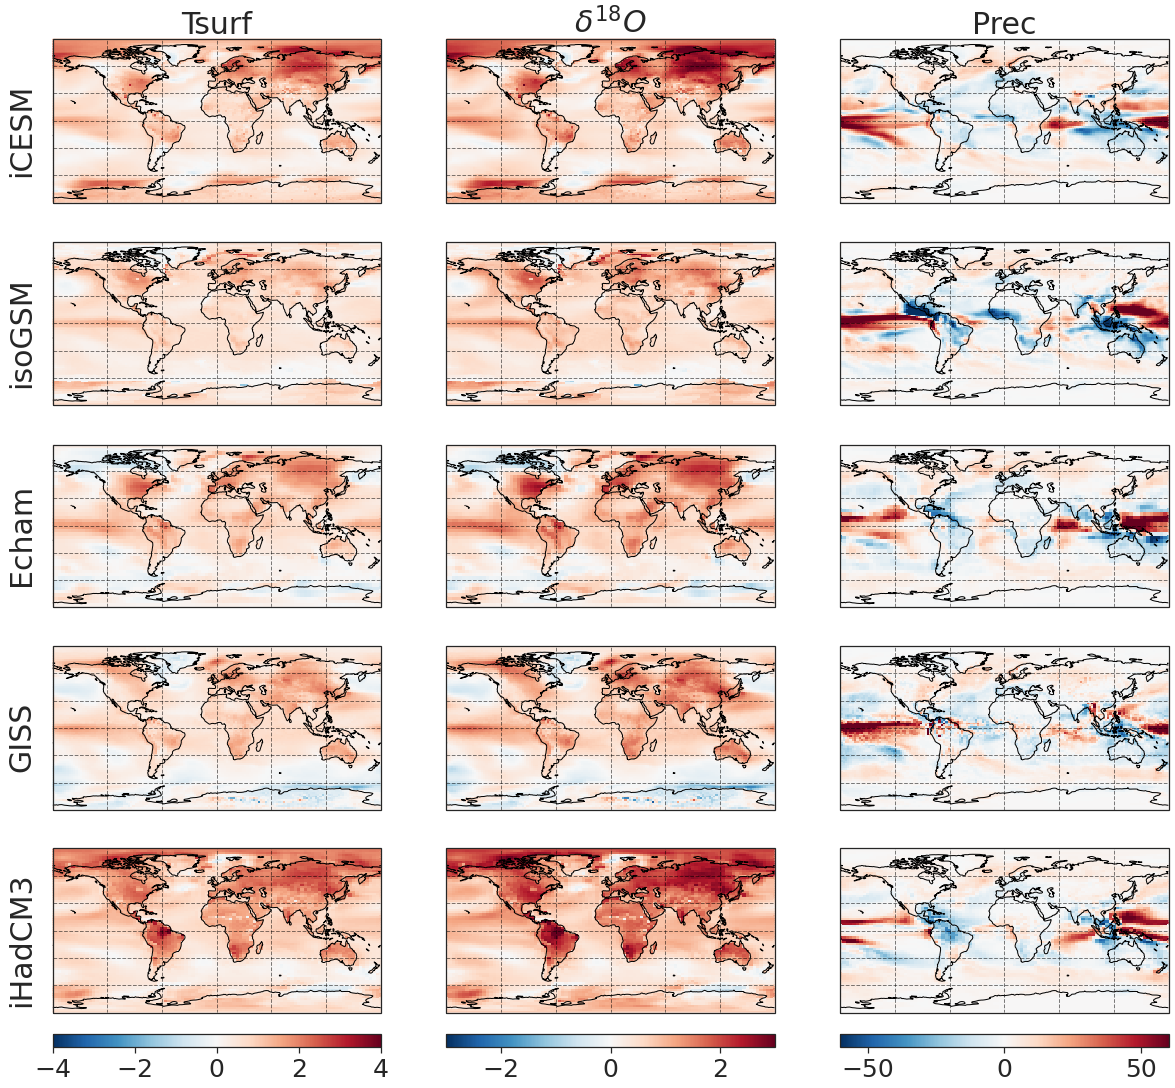

In [283]:
# SISAL + ISO2K

sns.set_theme(style="white")

#get first list item
conf=4

figsize=(20,18)
fig, axes = plt.subplots(ncols=3,nrows=5,figsize=figsize,subplot_kw={'projection':ccrs.PlateCarree()})

for i,m in enumerate(models):
    
    data=dic_models[m]['1'][conf]
    
    #temperature
    vmin=-4; vmax=4
    p1=data['tsurf'].plot(ax=axes[i,0],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)
    
    ax=axes[i,0]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_ylabel(m,fontsize=30,rotation=90)
    ax.set_xlabel('',fontsize=30,rotation=0)
    ax.yaxis.set_label_coords(-0.05,0.45)

    
    #d18O
    vmin=-3; vmax=3
    p2=data['tsurf'].plot(ax=axes[i,1],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)

    ax=axes[i,1]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_ylabel('',fontsize=50,rotation=0)
    ax.set_xlabel('',fontsize=30,rotation=0)

    
    #precipitation
    vmin=-60; vmax=60
    p3=data['prec'].plot(ax=axes[i,2],vmin=vmin,vmax=vmax,add_colorbar=False,cmap=plt.cm.RdBu_r)
    
    ax=axes[i,2]
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    ax.add_feature(cfeature.COASTLINE)
    ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')
    
    ax.set_xlabel('',fontsize=30,rotation=0)
    ax.set_ylabel('',fontsize=30,rotation=0)


    
p_0 = axes[-1,0].get_position().get_points().flatten()
p_1 = axes[-1,1].get_position().get_points().flatten()
p_2 = axes[-1,2].get_position().get_points().flatten()

ax_cbar = fig.add_axes([p_0[0], 0.1, p_0[2]-p_0[0], 0.01])
cbar=fig.colorbar(p1, cax=ax_cbar, orientation='horizontal')
#cbar=fig.colorbar(p1,ax=axes[-1,0],extend='max',aspect=12,pad=0.02,location='bottom')
cbar.ax.tick_params(labelsize=25)

ax_cbar = fig.add_axes([p_1[0], 0.1, p_1[2]-p_1[0], 0.01])
cbar=fig.colorbar(p2, cax=ax_cbar, orientation='horizontal')
cbar.ax.tick_params(labelsize=25)

ax_cbar = fig.add_axes([p_2[0], 0.1, p_2[2]-p_2[0], 0.01])
cbar=fig.colorbar(p3, cax=ax_cbar, orientation='horizontal')
cbar.ax.tick_params(labelsize=25)

"""
cm=plt.cm.RdBu_r    
ax_cbar1 = fig.add_axes([p1[0], 0.01, (p1[2]-p1[0]), 0.01])
cb=fig.colorbar(p1, cax=ax_cbar1, orientation='horizontal',cmap=cm)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
"""    

#cb.set_label('$\overline{{Proxy}}$ - $\overline{Simulation}$',fontsize=30)

axes[0,0].set_title('Tsurf',fontsize=30)
axes[0,1].set_title('$\delta^{18}O$',fontsize=30)
axes[0,2].set_title('Prec',fontsize=30)

#plt.tight_layout() 
    

In [254]:
p1

array([0.39852941, 0.13310091, 0.62647059, 0.2470715 ])

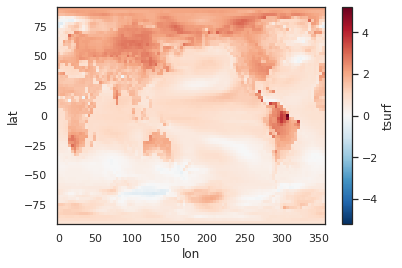

In [213]:
data['tsurf'].plot(cmap=plt.cm.RdBu_r)

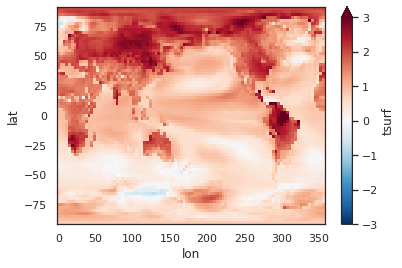

In [212]:
data['tsurf'].plot(vmax=3,vmin=-3,cmap=plt.cm.RdBu_r)

In [ ]:
metric='Corr'
title='SISAL locations (SNR=5)'
paths_dic=paths

sns.set_theme(style="white")

figsize=(15,25)
fig, axes = plt.subplots(ncols=3,nrows=5,sharex=False,sharey=True,figsize=figsize,subplot_kw={'projection':ccrs.PlateCarree()})
plt.suptitle(title,fontsize=30,y=0.85)

j=0
for i,(p,v) in enumerate(paths_dic.items()):
    if p!='iHadCM3':
        strg='tsurf_'+metric
        sisal=xr.open_dataset(paths_dic[p][2])[strg]
        #iso2k=xr.open_dataset(paths_dic[p][1])[strg]

        ax=axes[j]
        j+=1
        trans=ccrs.PlateCarree()

        #set colorbar limits
        if metric in ['Corr','CE']:
            vmin=-1
            vmax=1
            cmap='RdBu_r'

        colorbar=False
        plot=(sisal).plot(ax=ax,transform=trans,x='lon',y='lat',add_colorbar=colorbar,vmin=vmin,vmax=vmax,cmap=cmap)

        ax.axes.xaxis.set_visible(True)
        ax.axes.yaxis.set_visible(True)
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

        ax.add_feature(cfeature.COASTLINE)
        ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')

        #suppress all unwanted titles created by xrray
        ax.set_title(p,fontsize=20)

        ax.set_xlabel('',fontsize=30,rotation=0)
        ax.set_ylabel('',fontsize=30,rotation=0)
        ax.yaxis.set_label_coords(-0.15,0.4)

cbar=fig.colorbar(plot,ax=axes.ravel().tolist(),shrink=0.5,aspect=12,pad=0.02)
cbar.ax.tick_params(labelsize=25)

savefig='sisal_corr'
strg='/home/mchoblet/paleoda/results/plots/'+savefig+'.pdf'
plt.savefig(strg, format='pdf',bbox_inches='tight')
plt.show()

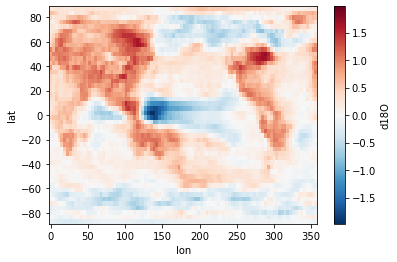

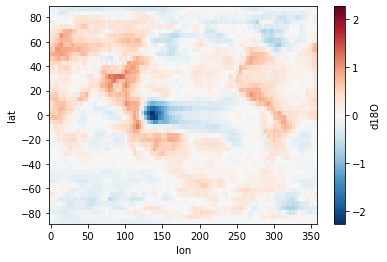

In [182]:
dic_models['Echam']['1'][0]['d18O'].plot()
plt.show()
dic_models['Echam']['1'][1]['d18O'].plot()

In [130]:
dic_models['GISS']['1'][0]['tsurf']

<xarray.DataArray 'tsurf' (lat: 90, lon: 144)>
array([[0.29487326, 0.29487326, 0.29487326, ..., 0.29487326, 0.29487326,
        0.29487326],
       [0.29102659, 0.29848221, 0.30292768, ..., 0.30377918, 0.30124861,
        0.30312668],
       [0.39947853, 0.40236433, 0.3941809 , ..., 0.35886239, 0.37680864,
        0.39459587],
       ...,
       [0.09835034, 0.31409373, 0.38735455, ..., 0.17641639, 0.24411529,
        0.34950809],
       [0.39041175, 0.20477003, 0.36645045, ..., 0.53157895, 0.48903226,
        0.38009525],
       [0.03267924, 0.03267924, 0.03267924, ..., 0.03267924, 0.03267924,
        0.03267924]])
Dimensions without coordinates: lat, lon

In [ ]:
dic_models['GISS']['1'][0]['tsurf'].plot()
plt.show()
dic_models['GISS']['1'][1]['tsurf'].plot()

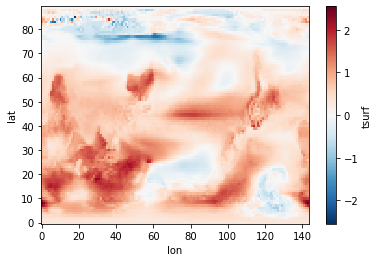

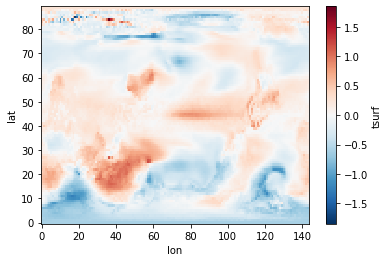

In [127]:
dic_models['GISS']['1'][0]['tsurf'].plot()
plt.show()
dic_models['GISS']['1'][1]['tsurf'].plot()

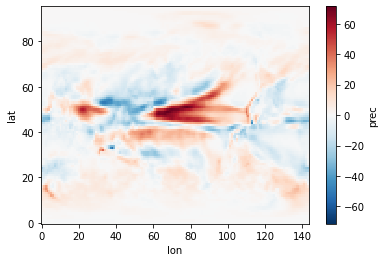

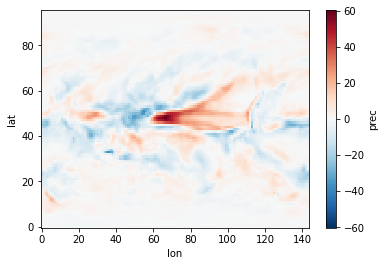

In [124]:
dic_models['iCESM']['1'][0]['prec'].plot()
plt.show()
dic_models['iCESM']['1'][1]['prec'].plot()

In [110]:
dic_models

{}

In [108]:
np.arange(5)

array([0, 1, 2, 3, 4])